Data-Driven Insights to Enhance Airbnb Occupancy by Team Airbnb-lytics



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import folium
from folium.plugins import MarkerCluster

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

!pip install langdetect
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=832db1cb682972737de7d136512bbd6ac2a02613c718bc2b21870c62e6ee2f08
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The Dataset

This project uses 'listings.csv' and 'reviews.csv' data on Singapore from Inside AirBnb Website uploaded 24 December 2024 and last scrapped on 29 September 2024 dataset.

*Inside Airbnb. (n.d.). Get the data - Singapore. Inside Airbnb [Dataset]. Retrieved January 17,
2025, from https://insideairbnb.com/get-the-data/*


In [ ]:
# load dataset via shared google drive folder
df_listings = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/data/listings.csv')
df_reviews = pd.read_csv('/content/drive/MyDrive/BAP Practice Module/data/reviews.csv')

# # Alternative load data via local file upload
# df_listings = pd.read_csv('listings.csv')
# df_reviews = pd.read_csv('reviews.csv')

In [ ]:
print(df_listings.head())

       id                          listing_url       scrape_id last_scraped  \
0  275343  https://www.airbnb.com/rooms/275343  20240926145704   2024-09-26   
1  275344  https://www.airbnb.com/rooms/275344  20240926145704   2024-09-26   
2  294281  https://www.airbnb.com/rooms/294281  20240926145704   2024-09-26   
3  324945  https://www.airbnb.com/rooms/324945  20240926145704   2024-09-26   
4  330095  https://www.airbnb.com/rooms/330095  20240926145704   2024-09-26   

        source                                               name  \
0  city scrape   10min walk to MRT & a Cozy Room with window! (1)   
1  city scrape              15 mins to Outram MRT Single Room (2)   
2  city scrape                     5 mins walk from Newton subway   
3  city scrape  Comfortable Room w/study area @ Redhill  MRT! (6)   
4  city scrape  Relaxing Mini Room near Redhill MRT-NOwindow  (4)   

                                         description  \
0  **IMPORTANT NOTES:  READ BEFORE YOU BOOK! <br ...  

In [ ]:
print(df_reviews.head())

   listing_id        id        date  reviewer_id reviewer_name  \
0      275343   4223592  2013-04-20      5492044         Carol   
1      275343   8818243  2013-11-19      7938877          Ying   
2      275343  26820048  2015-02-20     18071761            誼勳   
3      275343  28258248  2015-03-21     26579851         David   
4      275343  34945181  2015-06-14     29892169       Jessica   

                                            comments  
0  A newly renovated and clean apartment. Conveni...  
1  I am so glad that i chose the place. Joyce and...  
2  I enjoyed the time shared with the Woons. Joyc...  
3  The Woons are nice welcoming people, I had a g...  
4  I stayed with the Woon family for 3 weeks in M...  


# Data Profiling
Making sense of data before cleaning


In [ ]:
print(df_listings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3381 non-null   int64  
 1   listing_url                                   3381 non-null   object 
 2   scrape_id                                     3381 non-null   int64  
 3   last_scraped                                  3381 non-null   object 
 4   source                                        3381 non-null   object 
 5   name                                          3381 non-null   object 
 6   description                                   3294 non-null   object 
 7   neighborhood_overview                         2004 non-null   object 
 8   picture_url                                   3381 non-null   object 
 9   host_id                                       3381 non-null   i

In [ ]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39282 entries, 0 to 39281
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     39282 non-null  int64 
 1   id             39282 non-null  int64 
 2   date           39282 non-null  object
 3   reviewer_id    39282 non-null  int64 
 4   reviewer_name  39282 non-null  object
 5   comments       39272 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.8+ MB
None


In [ ]:
# min and max for numerical columns
print(df_listings.describe().loc[['min', 'max']])

               id     scrape_id      host_id  host_listings_count  \
min  2.753430e+05  2.024093e+13      23666.0                  1.0   
max  1.253502e+18  2.024093e+13  652077005.0                531.0   

     host_total_listings_count  latitude  longitude  accommodates  bathrooms  \
min                        1.0  1.221690  103.63457           1.0        0.0   
max                      886.0  1.457802  103.98957          16.0       21.0   

     bedrooms  ...  review_scores_cleanliness  review_scores_checkin  \
min       0.0  ...                        1.0                    1.0   
max      11.0  ...                        5.0                    5.0   

     review_scores_communication  review_scores_location  review_scores_value  \
min                          1.0                     1.0                  1.0   
max                          5.0                     5.0                  5.0   

     calculated_host_listings_count  \
min                             1.0   
max         

In [ ]:
# number of unique values for each column
listings_unique = df_listings.nunique()
reviews_unique= df_reviews.nunique()
print(listings_unique)
print(reviews_unique)

id                                              3381
listing_url                                     3381
scrape_id                                          1
last_scraped                                       1
source                                             2
                                                ... 
calculated_host_listings_count                    40
calculated_host_listings_count_entire_homes       23
calculated_host_listings_count_private_rooms      25
calculated_host_listings_count_shared_rooms       10
reviews_per_month                                262
Length: 75, dtype: int64
listing_id        1788
id               39282
date              3902
reviewer_id      36400
reviewer_name    16835
comments         37409
dtype: int64


In [ ]:
# check for duplicates
print("Number of duplicate rows in listings:", df_listings.duplicated().sum())
print("Number of duplicate rows in reviews:", df_reviews.duplicated().sum())

Number of duplicate rows in listings: 0
Number of duplicate rows in reviews: 0


In [ ]:
# check for missing values

## convert 'na', 'NA', etc., to NaN
df_listings.replace(["na", "NA", "N/A", "null", ""], pd.NA, inplace=True)
df_reviews.replace(["na", "NA", "N/A", "null", ""], pd.NA, inplace=True)

## check missing values
list_missing_data = df_listings.isnull().sum()
list_missing_data = list_missing_data[list_missing_data > 0]
print(list_missing_data)

review_missing_data = df_reviews.isnull().sum()
missing_data = review_missing_data[review_missing_data > 0]
print(review_missing_data)

description                      87
neighborhood_overview          1377
host_location                  1273
host_about                     1136
host_response_time              858
host_response_rate              858
host_acceptance_rate            961
host_is_superhost                25
host_neighbourhood              201
neighbourhood                  1377
bathrooms                       807
bathrooms_text                   16
bedrooms                        321
beds                            847
price                           807
calendar_updated               3381
has_availability                285
first_review                   1593
last_review                    1593
review_scores_rating           1593
review_scores_accuracy         1593
review_scores_cleanliness      1593
review_scores_checkin          1593
review_scores_communication    1593
review_scores_location         1593
review_scores_value            1593
license                        1890
reviews_per_month           

In [ ]:
# range of host since dates
df_listings['host_since'] = pd.to_datetime(df_listings['host_since'],
                                           errors='coerce')
print("Range of host_since dates:", df_listings['host_since'].min(),
      "to", df_listings['host_since'].max())

Range of host_since dates: 2009-06-29 00:00:00 to 2024-09-14 00:00:00


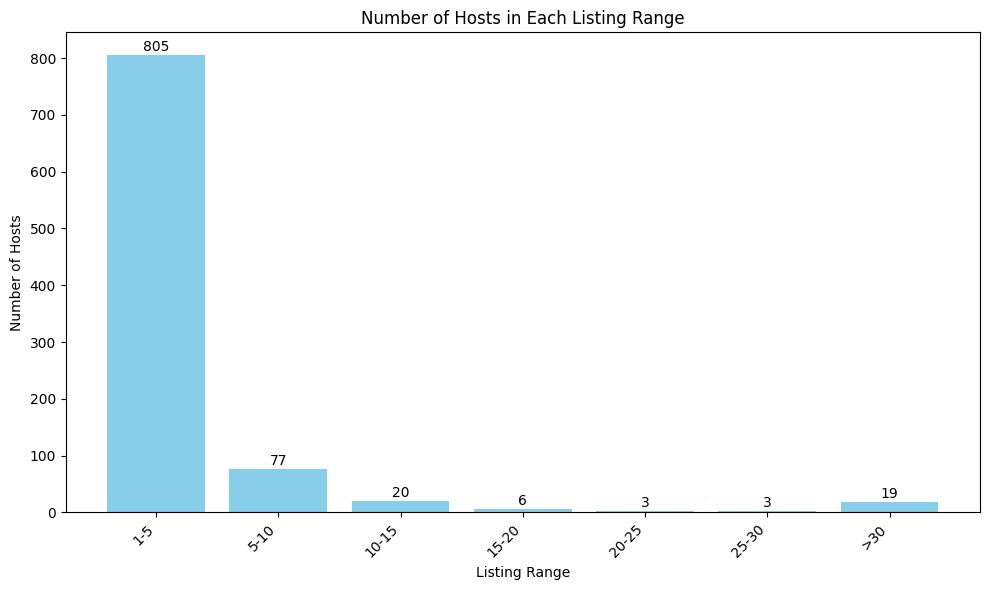

In [ ]:
# number of hosts in each listings range

## group by 'host_id' and count the number of listings for each host
host_listing_counts = df_listings.groupby('host_id').\
                      size().reset_index(name='listing_count')

## define the bins using the thresholds
bins = [0, 5, 10, 15, 20, 25, 30, float('inf')]
labels = ['1-5', '5-10','10-15','15-20','20-25','25-30','>30',]

## create a new column in the DataFrame with the binned values
host_listing_counts['listing_range'] = pd.cut(
                                        host_listing_counts['listing_count'],
                                        bins=bins, labels=labels, right=False)

## count the number of hosts in each range
listing_range_counts = host_listing_counts['listing_range'].value_counts().sort_index()

## plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(listing_range_counts.index, listing_range_counts.values,
               color='skyblue')
plt.title('Number of Hosts in Each Listing Range')
plt.xlabel('Listing Range')
plt.ylabel('Number of Hosts')
plt.xticks(rotation=45, ha='right')

## annotate the bars with the count of hosts
for bar in bars:
    yval = bar.get_height()  # value of bar height
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2,  # text position
             f'{int(yval)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

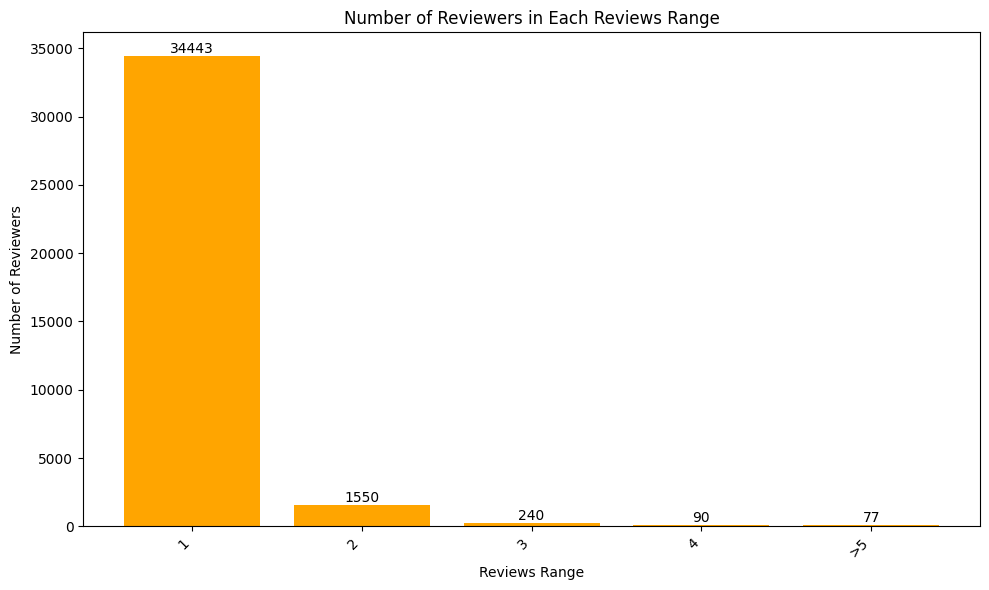

In [ ]:
# number of reviewers in each reviews range

## group by 'reviewer_id' and count the number of reviews for each reviewer
review_counts = df_reviews.groupby('reviewer_id').size().\
                                    reset_index(name='review_count')

## define the bins using the thresholds
bins = [1, 2, 3, 4, 5, float('inf')]
labels = ['1','2','3','4','>5']

## create a new column in the DataFrame with the binned values
review_counts['review_range'] = pd.cut(review_counts['review_count'],
                                       bins=bins, labels=labels, right=False)

## count the number of reviewers in each range
review_range_counts = review_counts['review_range'].value_counts().sort_index()

## plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(review_range_counts.index, review_range_counts.values,
               color='orange')
plt.title('Number of Reviewers in Each Reviews Range')
plt.xlabel('Reviews Range')
plt.ylabel('Number of Reviewers')
plt.xticks(rotation=45, ha='right')
## annotate the bars with the count of Reviewers
for bar in bars:
    yval = bar.get_height()  # value of bar height
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2,  # text position
             f'{int(yval)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# count of listings in each neighbourhood group
neighbourhood_counts = df_listings['neighbourhood_group_cleansed'].value_counts()
print("Count in each neighbourhood group:")
print(neighbourhood_counts)

Count in each neighbourhood group:
neighbourhood_group_cleansed
Central Region       2732
West Region           248
East Region           205
North-East Region     117
North Region           79
Name: count, dtype: int64


In [ ]:
# count of listings in each neighbourhood
print("Count in each neighbourhood:")
print(df_listings['neighbourhood_cleansed'].value_counts())


## load necessary data
df_map = df_listings[['latitude', 'longitude', 'neighbourhood_cleansed']].copy()

## aggregate count of listings per neighbourhood
neighbourhood_counts = df_map['neighbourhood_cleansed'].value_counts().reset_index()
neighbourhood_counts.columns = ['neighbourhood_cleansed', 'count']

## merge to get latitude and longitude for each neighbourhood
df_map = df_map.drop_duplicates(subset=['neighbourhood_cleansed']).merge(neighbourhood_counts, on='neighbourhood_cleansed')

## create a Folium map centered around Singapore
m = folium.Map(location=[df_map['latitude'].mean(), df_map['longitude'].mean()], zoom_start=11)

## add markers for each neighbourhood
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_map.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['neighbourhood_cleansed']}: {row['count']} listings",
        icon=folium.Icon(color='blue', icon="info-sign"),
    ).add_to(marker_cluster)

## display the map
m.save("neighbourhood_map.html")
m

Count in each neighbourhood:
neighbourhood_cleansed
Kallang                    357
Outram                     279
Rochor                     256
River Valley               251
Downtown Core              211
Queenstown                 198
Bukit Merah                197
Novena                     186
Geylang                    168
Bedok                      145
Singapore River            135
Marine Parade              106
Orchard                     85
Clementi                    83
Tanglin                     83
Newton                      78
Jurong West                 58
Bukit Timah                 44
Serangoon                   40
Jurong East                 37
Pasir Ris                   33
Hougang                     32
Bukit Batok                 31
Toa Payoh                   29
Tampines                    25
Sembawang                   25
Southern Islands            25
Bishan                      25
Woodlands                   25
Ang Mo Kio                  20
Yishun            

# Data Preparation

## 'listings.csv'

### Numerics + Missing Values Cleaning

In [ ]:
# removing irrelevant columns
columns_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url',
                   'host_name', 'host_thumbnail_url', 'host_picture_url', 'neighbourhood', 'calendar_updated',
                   'calendar_last_scraped', 'calendar_updated', 'property_type']

ndf_listings = df_listings.drop(columns_to_drop, axis='columns')

print(ndf_listings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 62 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            3381 non-null   int64         
 1   name                                          3381 non-null   object        
 2   description                                   3294 non-null   object        
 3   neighborhood_overview                         2004 non-null   object        
 4   host_id                                       3381 non-null   int64         
 5   host_since                                    3381 non-null   datetime64[ns]
 6   host_location                                 2108 non-null   object        
 7   host_about                                    2245 non-null   object        
 8   host_response_time                            2523 non-null   object

In [ ]:
# change date-time data type
ndf_listings['host_since'] = pd.to_datetime(ndf_listings['host_since'], errors='coerce')
ndf_listings['first_review'] = pd.to_datetime(ndf_listings['first_review'], errors='coerce')
ndf_listings['last_review'] = pd.to_datetime(ndf_listings['last_review'], errors='coerce')

# print(ndf_listings.info())

In [ ]:
# handling missing host_location, host_response_time, host_neighbourhood

## blanks replace with "unknown"
ndf_listings['host_location'] = ndf_listings['host_location'].fillna('unknown')
ndf_listings['host_response_time'] = ndf_listings['host_response_time'].fillna('unknown')
ndf_listings['host_neighbourhood'] = ndf_listings['host_neighbourhood'].fillna('unknown')

# print(ndf_listings.info())

In [ ]:
# handling missing data and change data type for host_response_rate and host_acceptance_rate
## remove percentage
ndf_listings['host_response_rate'] = df_listings['host_response_rate'].astype(str).str.rstrip('%')
ndf_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].astype(str).str.rstrip('%')

## make blanks consistent
ndf_listings['host_response_rate'] = ndf_listings['host_response_rate'].replace(['', 'nan', '<NA>'], np.nan)
ndf_listings['host_acceptance_rate'] = ndf_listings['host_acceptance_rate'].replace(['', 'nan', '<NA>'], np.nan)

## replace blanks with 0 and convert to integer
ndf_listings['host_response_rate'] = ndf_listings['host_response_rate'].astype(float).fillna(0).astype(int)
ndf_listings['host_acceptance_rate'] = ndf_listings['host_acceptance_rate'].astype(float).fillna(0).astype(int)


# print(ndf_listings.info())
# print(ndf_listings.head())

In [ ]:
# handling missing bathrooms data with first character of bathroom text
ndf_listings['bathrooms'] = ndf_listings['bathrooms']\
                            .fillna(ndf_listings['bathrooms_text'].astype(str).str[0])

## replace H, P and S with 0.5 (all are half shared bathrooms)
ndf_listings['bathrooms'] = ndf_listings['bathrooms'].replace(['H', 'P', 'S'], 0.5)
ndf_listings['bathrooms'] = ndf_listings['bathrooms'].replace(['n'], 0)

# print(ndf_listings['bathrooms'].value_counts())
ndf_listings['bathrooms'] = ndf_listings['bathrooms'].astype(float)

## remove bathroom_text column
ndf_listings = ndf_listings.drop('bathrooms_text', axis=1)

print(ndf_listings['bathrooms'].value_counts())

bathrooms
1.0     2191
2.0      580
3.0      234
1.5      138
0.5       51
0.0       51
4.0       47
7.0       20
5.0       17
2.5       16
8.0       15
6.0        6
4.5        3
3.5        3
10.0       3
21.0       2
9.0        2
8.5        1
5.5        1
Name: count, dtype: int64


In [ ]:
# handling missing bedrooms and beds values

## replace blanks with 0
ndf_listings['beds'] = ndf_listings['beds'].fillna(0)
ndf_listings['bedrooms'] = ndf_listings['bedrooms'].fillna(0)

ndf_listings['beds'] = ndf_listings['beds'].astype(int)
ndf_listings['bedrooms'] = ndf_listings['bedrooms'].astype(int)

print(ndf_listings['beds'].value_counts())
print(ndf_listings['bedrooms'].value_counts())

beds
1     1613
0      888
2      469
3      205
4      108
6       35
5       24
8        9
10       9
9        7
7        3
12       3
14       2
16       1
30       1
46       1
20       1
24       1
15       1
Name: count, dtype: int64
bedrooms
1     2169
0      523
2      441
3      190
4       43
5        7
6        5
10       1
7        1
11       1
Name: count, dtype: int64


In [ ]:
# handling missing price values

## remove dollar sign and commas
ndf_listings['price'] = ndf_listings['price'].str.replace('$', '')
ndf_listings['price'] = ndf_listings['price'].str.replace(',', '')

## replace as 0
ndf_listings['price'] = ndf_listings['price'].replace(['', 'nan', '<NA>'], np.nan)
ndf_listings['price'] = ndf_listings['price'].astype(float).fillna(0)

print(ndf_listings['price'].value_counts())

price
0.0       807
49.0       99
59.0       62
69.0       44
250.0      36
         ... 
421.0       1
327.0       1
747.0       1
161.0       1
2656.0      1
Name: count, Length: 563, dtype: int64


In [ ]:
# handling missing license, replace blanks with unknown
ndf_listings['license'] = ndf_listings['license'].fillna('unknown')

print(ndf_listings['license'].value_counts())

license
unknown                          1890
Authorised Serviced Apartment     948
S0399                              75
S0430                              17
S0451                              16
                                 ... 
S9020                               1
S0587                               1
M8279                               1
M8281                               1
M8280                               1
Name: count, Length: 122, dtype: int64


In [ ]:
# handling missing reviews

## remove rows where beds = 0, price = 0, and has_availability = 0
## equivalent to listings with no avilaiblity and no price stated -> not functioning
ndf_listings = ndf_listings.query("beds != 0 & price != 0 & has_availability != 0")

## remaining blank reviews to replace with 0 and no_comments
ndf_listings['review_scores_rating'] = ndf_listings['review_scores_rating'].fillna(0)
ndf_listings['review_scores_accuracy'] = ndf_listings['review_scores_accuracy'].fillna(0)
ndf_listings['review_scores_cleanliness'] = ndf_listings['review_scores_cleanliness'].fillna(0)
ndf_listings['review_scores_checkin'] = ndf_listings['review_scores_checkin'].fillna(0)
ndf_listings['review_scores_communication'] = ndf_listings['review_scores_communication'].fillna(0)
ndf_listings['review_scores_location'] = ndf_listings['review_scores_location'].fillna(0)
ndf_listings['review_scores_value'] = ndf_listings['review_scores_value'].fillna(0)
ndf_listings['number_of_reviews'] = ndf_listings['number_of_reviews'].fillna(0)

## replace blanks with 0 for reviews_per_month
ndf_listings['reviews_per_month'] = ndf_listings['reviews_per_month'].fillna(0)

## fill blanks with dummy date '1999-01-01' for first_review and last_review
ndf_listings['first_review'] = ndf_listings['first_review'].fillna('1999-01-01')
ndf_listings['last_review'] = ndf_listings['last_review'].fillna('1999-01-01')

<ipython-input-118-de6520f4e3da>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf_listings['review_scores_rating'] = ndf_listings['review_scores_rating'].fillna(0)
<ipython-input-118-de6520f4e3da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf_listings['review_scores_accuracy'] = ndf_listings['review_scores_accuracy'].fillna(0)
<ipython-input-118-de6520f4e3da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
# dummy values for host_response_time to change to numerical categories
response_time_mapping = {
    'unknown': 0,
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}

ndf_listings['host_response_time'] = ndf_listings['host_response_time'].map(response_time_mapping).astype(int)

print(ndf_listings['host_response_time'].value_counts())
# print(ndf_listings[['host_response_time']].head())

host_response_time
1    1077
2     517
3     458
0     315
4     126
Name: count, dtype: int64


In [ ]:
# dummy values for host_is_superhost, host_has_profile_pic, host_identity_verified, has_availability
## blanks replace with "uk"
ndf_listings['host_is_superhost'] = ndf_listings['host_is_superhost'].fillna('uk')
ndf_listings['host_has_profile_pic'] = ndf_listings['host_has_profile_pic'].fillna('uk')
ndf_listings['host_identity_verified'] = ndf_listings['host_identity_verified'].fillna('uk')
ndf_listings['has_availability'] = ndf_listings['has_availability'].fillna('uk')
ndf_listings['instant_bookable'] = ndf_listings['instant_bookable'].fillna('uk')


tf_mapping = {'uk': 0,'t': 1, 'f': 2}

## apply mapping, replace blanks (NaN) with 0
ndf_listings['host_is_superhost'] = ndf_listings['host_is_superhost'].map(tf_mapping).fillna(0).astype(int)
ndf_listings['host_has_profile_pic'] = ndf_listings['host_has_profile_pic'].map(tf_mapping).fillna(0).astype(int)
ndf_listings['host_identity_verified'] = ndf_listings['host_identity_verified'].map(tf_mapping).fillna(0).astype(int)
ndf_listings['has_availability'] = ndf_listings['has_availability'].map(tf_mapping).fillna(0).astype(int)
ndf_listings['instant_bookable'] = ndf_listings['instant_bookable'].map(tf_mapping).fillna(0).astype(int)

print(ndf_listings['host_is_superhost'].value_counts())
print(ndf_listings['host_has_profile_pic'].value_counts())
print(ndf_listings['host_identity_verified'].value_counts())
print(ndf_listings['has_availability'].value_counts())
# print(ndf_listings.head())

host_is_superhost
2    2056
1     420
0      17
Name: count, dtype: int64
host_has_profile_pic
1    2412
2      81
Name: count, dtype: int64
host_identity_verified
1    2402
2      91
Name: count, dtype: int64
has_availability
1    2481
0      11
2       1
Name: count, dtype: int64


In [ ]:
# dummy variable for room_type to change to numerical categories
room_type_mapping = {
    'Entire home/apt': 1,
    'Hotel room': 2,
    'Private room': 3,
    'Shared room': 4
}

ndf_listings['room_type'] = ndf_listings['room_type'].map(room_type_mapping).astype(int)

print(ndf_listings['room_type'].value_counts())
# print(ndf_listings[['room_type']].head())

room_type
1    1250
3    1084
4     124
2      35
Name: count, dtype: int64


In [ ]:
ndf_listings.head()

,id,name,description,neighborhood_overview,host_id,host_since,host_location,host_about,host_response_time,host_response_rate,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,275343,10min walk to MRT & a Cozy Room with window! (1),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,4.42,4.53,4.63,S0399,1,51,0,51,0,0.14
1,275344,15 mins to Outram MRT Single Room (2),Lovely home for the special guest !,Bus stop <br />Food center <br />Supermarket,1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,4.50,4.63,4.13,S0399,1,51,0,51,0,0.11
2,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,NaN,1521514,2011-12-20,Singapore,Hello !\r\nI am Elizabeth from Singapore.\r\n\...,0,0,...,4.66,4.52,4.39,unknown,2,7,1,6,0,0.85
3,324945,Comfortable Room w/study area @ Redhill MRT! (6),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,4.06,3.82,3.76,S0399,2,51,0,51,0,0.11
4,330095,Relaxing Mini Room near Redhill MRT-NOwindow (4),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,"Near IKEA Alexandra Singapore, Food markets an...",1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,4.80,3.80,4.00,S0399,1,51,0,51,0,0.04


In [ ]:
ndf_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2493 entries, 0 to 3380
Data columns (total 61 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            2493 non-null   int64         
 1   name                                          2493 non-null   object        
 2   description                                   2454 non-null   object        
 3   neighborhood_overview                         1583 non-null   object        
 4   host_id                                       2493 non-null   int64         
 5   host_since                                    2493 non-null   datetime64[ns]
 6   host_location                                 2493 non-null   object        
 7   host_about                                    1835 non-null   object        
 8   host_response_time                            2493 non-null   int64      

### Text Cleaning

#### Translation

In [ ]:
# extract text fields
text_fields = ['id','name', 'description', 'neighborhood_overview', 'host_about']
df_listings_text = ndf_listings[text_fields]  # continue from cleaned_lisitngs
df_listings_text.head()

,id,name,description,neighborhood_overview,host_about
0,275343,10min walk to MRT & a Cozy Room with window! (1),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,K2 Guesthouse is designed for guests who want ...
1,275344,15 mins to Outram MRT Single Room (2),Lovely home for the special guest !,Bus stop <br />Food center <br />Supermarket,K2 Guesthouse is designed for guests who want ...
2,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,NaN,Hello !\r\nI am Elizabeth from Singapore.\r\n\...
3,324945,Comfortable Room w/study area @ Redhill MRT! (6),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,K2 Guesthouse is designed for guests who want ...
4,330095,Relaxing Mini Room near Redhill MRT-NOwindow (4),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,"Near IKEA Alexandra Singapore, Food markets an...",K2 Guesthouse is designed for guests who want ...


In [ ]:
# function to check if text data is in English
def is_english(text):
    if pd.isnull(text):
        return False
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

In [ ]:
# apply is_english function to all df_lisintgs_text columns
df_listings_text.loc[:, 'is_english'] = df_listings_text[['name', 'description', 'neighborhood_overview', 'host_about']].apply(
    lambda row: all(is_english(str(val)) for val in row if pd.notnull(val)), axis=1
)

# Get non-English entries
df_listings_non_english = df_listings_text.loc[~df_listings_text['is_english'], df_listings_text.columns]

# Display non-English entries
df_listings_non_english

<ipython-input-38-5a397f771768>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_text.loc[:, 'is_english'] = df_listings_text[['name', 'description', 'neighborhood_overview', 'host_about']].apply(


,id,name,description,neighborhood_overview,host_about,is_english
1,275344,15 mins to Outram MRT Single Room (2),Lovely home for the special guest !,Bus stop <br />Food center <br />Supermarket,K2 Guesthouse is designed for guests who want ...,False
13,654191,Partial-Ensuite bedroom+Living room @ farrerpark,This Room's features include:<br />+ Personal ...,- Apartment is within area of petain road/kitc...,"Managing 88 rooms of various budgets, types an...",False
37,1508829,Lavender QueenBed *rmFr: 5m walk MRT,"- Airconditioned Double-bed/Queen-size room, w...",- Apartment is within lavender neighbourhood (...,"Managing 88 rooms of various budgets, types an...",False
48,1710048,Fireworks view8! highrise Ensuite Not4 Tourist,"+ Lockable Room & Fully Private, Airconditione...",- Apartment is at Chinatown MRT exit C.<br />-...,We rent rooms on behalf of various owners in s...,False
53,2129215,Luxuriously Spacious Studio Apt.,Just 4 min from the Kembangan MRT station...a ...,The neighbourhood is part of what the apartmen...,Homely & Friendly,False
...,...,...,...,...,...,...
3346,1239034501912776786,Room at Tanah Merah MRT - Near Expo,3mins walk to Tanah Merah MRT <br />1 MRT stat...,NaN,NaN,False
3348,1241036805012484393,Beautiful 2 bedrooms apartment,Have fun with the whole family at this stylish...,NaN,Dubai property agt,False
3349,1241238978192145855,新加坡的公寓式酒店内的房间,Studio (No Window) Apartment is perfect for a ...,NaN,NaN,False
3369,1245858798730925675,Bali resort luxury condo,Beautiful one bedroom plus one study (can be t...,NaN,"Hi, my name is Peng, a tech professional and y...",False


In [ ]:
# export non_english entries as csv file for translation
df_listings_non_english.to_csv('df_non_english.csv', index=False)

Exported non_english entries to seperate notebook for translation. Please see: https://colab.research.google.com/drive/1APggpWJMXeC0rb-hnIliDaBgllG9Pjdx?usp=drive_link and https://colab.research.google.com/drive/1NpBEkJ2hINvZIp0k0l-GMpX20mH3_TQy?usp=sharing




After translation, translated csv file imported to combine with english entries.

In [ ]:
# import translated csv file
df_listings_translated = pd.read_csv('df_translated.csv')

## drop is_english columns
df_listings_translated = df_listings_translated.drop('is_english', axis=1)

## change the df_listings_translated column names
df_listings_translated.columns = ['id', 'name', 'description', 'neighborhood_overview', 'host_about']
df_listings_translated

df_listings_translated.head()

,id,name,description,neighborhood_overview,host_about
0,275343,10min walk to MRT & a Cozy Room with window! (1),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,K2 Guesthouse is designed for guests who want ...
1,275344,15 mins to Outram MRT Single Room (2),Lovely home for the special guest !,Bus stop <br />Food center <br />Supermarket,K2 Guesthouse is designed for guests who want ...
2,654191,Partial-Ensuite bedroom+Living room @ farrerpark,This Room's features include:<br />+ Personal ...,- Apartment is within area of petain road/kitc...,"Managing 88 rooms of various budgets, types an..."
3,1508829,Lavender QueenBed *rmFr: 5m walk MRT,"- Airconditioned Double-bed/Queen-size room, w...",- Apartment is within lavender neighbourhood (...,"Managing 88 rooms of various budgets, types an..."
4,1710048,Fireworks view8! highrise Ensuite Not4 Tourist,"+ Lockable Room & Fully Private, Airconditione...",- Apartment is at Chinatown MRT exit C.<br />-...,We rent rooms on behalf of various owners in s...


In [ ]:
# get english entries in original df_listings_english
df_listings_english = df_listings_text.loc[df_listings_text['is_english'], df_listings_text.columns]

## drop is_english column
df_listings_english = df_listings_english.drop('is_english', axis=1)

df_listings_english

,id,name,description,neighborhood_overview,host_about
0,275343,10min walk to MRT & a Cozy Room with window! (1),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,K2 Guesthouse is designed for guests who want ...
2,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,NaN,Hello !\r\nI am Elizabeth from Singapore.\r\n\...
3,324945,Comfortable Room w/study area @ Redhill MRT! (6),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,K2 Guesthouse is designed for guests who want ...
4,330095,Relaxing Mini Room near Redhill MRT-NOwindow (4),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,"Near IKEA Alexandra Singapore, Food markets an...",K2 Guesthouse is designed for guests who want ...
5,344803,Budget short stay room near EXPO,Direct bus 24 from airport to this place.Walki...,A very quiet place .Very near to airport and c...,Hi My name is Belinda -Housekeeper \n\nI would...
...,...,...,...,...,...
3375,1249950404761886912,Transient Room near Khatib MRT,Transient Room for 2pax near Khatib MRT $60/da...,NaN,NaN
3376,1250286484789551883,"Spacious Studio Apartment, River Valley",Keep it simple at this peaceful self contained...,NaN,NaN
3378,1250664127604301004,Fabulous 2 br at Orchard,This stylish place to stay is perfect for grou...,NaN,I have been into Hospitality since long and ca...
3379,1252083926209830706,Fabulous studio at Orchard,The studio is located in the heart of Singapor...,NaN,I have been into Hospitality since long and ca...


In [ ]:
# combine df_listings_english and df_listings_translated
df_listings_textf_translated = pd.concat([df_listings_english, df_listings_translated], ignore_index=True)
df_listings_textf_translated

,id,name,description,neighborhood_overview,host_about
0,275343,10min walk to MRT & a Cozy Room with window! (1),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,K2 Guesthouse is designed for guests who want ...
1,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,NaN,Hello !\r\nI am Elizabeth from Singapore.\r\n\...
2,324945,Comfortable Room w/study area @ Redhill MRT! (6),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,K2 Guesthouse is designed for guests who want ...
3,330095,Relaxing Mini Room near Redhill MRT-NOwindow (4),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,"Near IKEA Alexandra Singapore, Food markets an...",K2 Guesthouse is designed for guests who want ...
4,344803,Budget short stay room near EXPO,Direct bus 24 from airport to this place.Walki...,A very quiet place .Very near to airport and c...,Hi My name is Belinda -Housekeeper \n\nI would...
...,...,...,...,...,...
2507,1239034501912776786,Room at Red Land MRT - Near Expo,3mins walk to Tanah Merah MRT <br />1 MRT stat...,NaN,NaN
2508,1241036805012484393,Beautiful 2 bedrooms apartment,Have fun with the whole family at this stylish...,NaN,Dubai property agt
2509,1241238978192145855,Rooms in an apartment hotel in Singapore,Studio (No Window) Apartment is perfect for a ...,NaN,NaN
2510,1245858798730925675,Bali resort luxury condo,Beautiful one bedroom plus one study (can be t...,NaN,"Hi, my name is Peng, a tech professional and y..."


#### Text Preprocessing

In [ ]:
# function to clean and process our texts

def preprocess_text(text):
    # Check if the input is a string
    if isinstance(text, str):
        stop_words = set(stopwords.words('english'))
        text = text.lower()  # Convert to lowercase
        text = ''.join([ch for ch in text if ch not in string.punctuation])  # remove punctuation
        tokens = nltk.word_tokenize(text)  # Tokenize
        tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
        return ' '.join(tokens)
    else:
        # Handle non-string inputs (e.g., float)
        return ''  # or any other appropriate handling

In [ ]:
# Apply preprocess_text function to specified columns and create new columns
df_listings_textf_translated['name_tokens'] = df_listings_textf_translated['name'].apply(preprocess_text)
df_listings_textf_translated['description_tokens'] = df_listings_textf_translated['description'].apply(preprocess_text)
df_listings_textf_translated['neighborhood_overview_tokens'] = df_listings_textf_translated['neighborhood_overview'].apply(preprocess_text)
df_listings_textf_translated['host_about_tokens'] = df_listings_textf_translated['host_about'].apply(preprocess_text)


df_listing_tokens = df_listings_textf_translated.drop(columns=['name', 'description', 'neighborhood_overview', 'host_about'])
df_listing_tokens

,id,name_tokens,description_tokens,neighborhood_overview_tokens,host_about_tokens
0,275343,10min walk mrt cozy room window 1,important notes read book br since hdb flat to...,,k2 guesthouse designed guests want truly local...
1,294281,5 mins walk newton subway,3 bedrooms charming british style townhouse fa...,,hello elizabeth singapore looking forward host...
2,324945,comfortable room wstudy area redhill mrt 6,important notes read book br since hdb flat to...,,k2 guesthouse designed guests want truly local...
3,330095,relaxing mini room near redhill mrtnowindow 4,important notes read book br since hdb flat to...,near ikea alexandra singapore food markets con...,k2 guesthouse designed guests want truly local...
4,344803,budget short stay room near expo,direct bus 24 airport placewalking distance ex...,quiet place near airport hear airplane sound,hi name belinda housekeeper would like welcome...
...,...,...,...,...,...
2507,1239034501912776786,room red land mrt near expo,3mins walk tanah merah mrt br 1 mrt station ex...,,
2508,1241036805012484393,beautiful 2 bedrooms apartment,fun whole family stylish place,,dubai property agt
2509,1241238978192145855,rooms apartment hotel singapore,studio window apartment perfect quiet getaway ...,,
2510,1245858798730925675,bali resort luxury condo,beautiful one bedroom plus one study turned 2 ...,,hi name peng tech professional yoga teacher ’ ...


In [ ]:
# export df_listing_tokens
df_listing_tokens.to_csv('df_listing_tokens.csv', index=False)

## Forming Data Model



In [ ]:
# merge in df_listing_tokens with ndf_listings for preprocessed text columns
ndf_listings = ndf_listings.merge(df_listing_tokens, on='id')

ndf_listings.head()

,id,name,description,neighborhood_overview,host_id,host_since,host_location,host_about,host_response_time,host_response_rate,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,name_tokens,description_tokens,neighborhood_overview_tokens,host_about_tokens
0,275343,10min walk to MRT & a Cozy Room with window! (1),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,1,51,0,51,0,0.14,10min walk mrt cozy room window 1,important notes read book br since hdb flat to...,,k2 guesthouse designed guests want truly local...
1,275343,10min walk to MRT & a Cozy Room with window! (1),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,1,51,0,51,0,0.14,10min walk mrt cozy room window 1,important notes read book br since hdb flat to...,,k2 guesthouse designed guests want truly local...
2,275344,15 mins to Outram MRT Single Room (2),Lovely home for the special guest !,Bus stop <br />Food center <br />Supermarket,1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,1,51,0,51,0,0.11,15 mins outram mrt single room 2,lovely home special guest,bus stop br food center br supermarket,k2 guesthouse designed guests want truly local...
3,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,NaN,1521514,2011-12-20,Singapore,Hello !\r\nI am Elizabeth from Singapore.\r\n\...,0,0,...,2,7,1,6,0,0.85,5 mins walk newton subway,3 bedrooms charming british style townhouse fa...,,hello elizabeth singapore looking forward host...
4,324945,Comfortable Room w/study area @ Redhill MRT! (6),**IMPORTANT NOTES: READ BEFORE YOU BOOK! <br ...,NaN,1439258,2011-11-24,Singapore,K2 Guesthouse is designed for guests who want ...,1,100,...,2,51,0,51,0,0.11,comfortable room wstudy area redhill mrt 6,important notes read book br since hdb flat to...,,k2 guesthouse designed guests want truly local...


In [ ]:
# drop the original text columns (keep the processed tokens)
ndf_listings.drop(columns=['description',
                           'name', 'neighborhood_overview',
                           'host_about'], inplace=True)
ndf_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 61 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            2512 non-null   int64         
 1   host_id                                       2512 non-null   int64         
 2   host_since                                    2512 non-null   datetime64[ns]
 3   host_location                                 2512 non-null   object        
 4   host_response_time                            2512 non-null   int64         
 5   host_response_rate                            2512 non-null   int64         
 6   host_acceptance_rate                          2512 non-null   int64         
 7   host_is_superhost                             2512 non-null   int64         
 8   host_neighbourhood                            2512 non-null   object

In [ ]:
# for the full cleaned file, not put into model
ndf_listings.to_csv('cleaned_listings.csv', index=False)

In [ ]:
# split table into dim_listings & dim_hosts for data model

host_features = ['host_id', 'host_since', 'host_location', 'host_about_tokens',
                 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
                 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic',
                 'host_identity_verified', 'license', 'calculated_host_listings_count',
                 'calculated_host_listings_count_entire_homes',
                 'calculated_host_listings_count_private_rooms',
                 'calculated_host_listings_count_shared_rooms']

availability_features = ['id', 'has_availability', 'availability_30', 'availability_60',
                         'availability_90', 'availability_365']

dim_hosts = ndf_listings[host_features]
fact_availability = ndf_listings[availability_features]

dim_listings = ndf_listings.drop(host_features, axis=1)
dim_listings = dim_listings.drop(availability_features, axis=1)
dim_listings.insert(0, 'id', ndf_listings['id'])
dim_listings.insert(1, 'host_id', ndf_listings['host_id'])

print(dim_hosts.info())
print(fact_availability.info())
print(dim_listings.info())


dim_hosts.to_csv('dim_hosts.csv', index=False)
fact_availability.to_csv('fact_availability.csv', index=False)
dim_listings.to_csv('dim_listings.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   host_id                                       2512 non-null   int64         
 1   host_since                                    2512 non-null   datetime64[ns]
 2   host_location                                 2512 non-null   object        
 3   host_about_tokens                             2512 non-null   object        
 4   host_response_time                            2512 non-null   int64         
 5   host_response_rate                            2512 non-null   int64         
 6   host_acceptance_rate                          2512 non-null   int64         
 7   host_is_superhost                             2512 non-null   int64         
 8   host_neighbourhood                            2512 non-null   object

## 'reviews.csv'

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39282 entries, 0 to 39281
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     39282 non-null  int64 
 1   id             39282 non-null  int64 
 2   date           39282 non-null  object
 3   reviewer_id    39282 non-null  int64 
 4   reviewer_name  39282 non-null  object
 5   comments       39269 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.8+ MB


In [ ]:
# change comments datatype to str
df_reviews['comments'] = df_reviews['comments'].astype(str)

In [ ]:
# handling missing values
df_reviews['comments'] = df_reviews['comments'].fillna("")

df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,275343,4223592,2013-04-20,5492044,Carol,A newly renovated and clean apartment. Conveni...
1,275343,8818243,2013-11-19,7938877,Ying,I am so glad that i chose the place. Joyce and...
2,275343,26820048,2015-02-20,18071761,誼勳,I enjoyed the time shared with the Woons. Joyc...
3,275343,28258248,2015-03-21,26579851,David,"The Woons are nice welcoming people, I had a g..."
4,275343,34945181,2015-06-14,29892169,Jessica,I stayed with the Woon family for 3 weeks in M...


### Translation

In [ ]:
# # function to check if text data is in English
# def is_english(text):
#     if pd.isnull(text):
#         return False
#     try:
#         return detect(text) == 'en'
#     except LangDetectException:
#         return False

In [ ]:
# check entries that are in english
df_reviews.loc[:, 'is_english'] = df_reviews[['comments']].apply(
    lambda row: all(is_english(str(val)) for val in row if pd.notnull(val)), axis=1
)

# get non-english entries
df_reviews_non_english = df_reviews.loc[~df_reviews['is_english'], df_reviews.columns]

# display non-english entries
df_reviews_non_english

,listing_id,id,date,reviewer_id,reviewer_name,comments,is_english
25,275344,23567853,2014-12-05,6176057,Felix,Ich war 3 Wochen lang bei Familie Woon unterge...,False
28,275344,322357295,2018-09-13,187213998,Nergi,nice,False
31,275344,718948967,2020-12-27,377615644,认证手机用户1855,如果想要旅行不建议，公共交通非常不方便，想要好好休息也不建议，任何时间都非常吵。但是现在的房...,False
34,275344,942422133723231911,2023-07-24,395272366,Sabrina,"Appartement bien placé, ligne 63 se trouve au ...",False
58,294281,3436244,2013-01-29,4099145,Dima,Жилье находится в тихом месте между двух больш...,False
...,...,...,...,...,...,...,...
39272,1217913244382728079,1231656600314214762,2024-08-26,110715107,Jing,地理位置：<br/> 就在南桥路大马路边上，出租车来这里很方便，酒店门口下。距离...,False
39273,1217913244382728079,1232271308096648348,2024-08-27,51323468,Suil,"샤워실 문은 안닫히고, 악취, 이상한 소리도 계속 나구요. 관리하는 사람이 있는 건...",False
39274,1217913244382728079,1232354589334502931,2024-08-27,8286294,Barbara,"Posizione perfetta e, anche se in modalità co-...",False
39275,1217913244382728079,1239638049832169399,2024-09-06,388778215,한영,가격대비 보통인 편임,False


In [ ]:
 #export df_non_english_reviews as csv file for translation
df_reviews_non_english.to_csv('df_non_english_reviews.csv', index=False)

Exported non_english entries to seperate notebook for translation. Please see: https://colab.research.google.com/drive/1zbhVdQTCFPy-thea5L_lQDIVLYcX2vyj?usp=share_link


After translation, translated csv file imported to combine with english entries.

In [ ]:
# import translated csv file
df_reviews_translated = pd.read_csv('df_reviews_translated.csv')

# drop comments and is_english columns
df_reviews_translated = df_reviews_translated.drop(['comments', 'is_english'], axis=1)

# rename column
df_reviews_translated.rename(columns={'comments_translated': 'comments'}, inplace=True)

df_reviews_translated

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,275344,23567853,2014-12-05,6176057,Felix,I had been with the Woon family for 3 weeks an...
1,275344,322357295,2018-09-13,187213998,Nergi,nice
2,275344,718948967,2020-12-27,377615644,认证手机用户1855,"If you want to travel, it is not recommended, ..."
3,275344,942422133723231911,2023-07-24,395272366,Sabrina,"Apartment well placed, line 63 is on the groun..."
4,294281,3436244,2013-01-29,4099145,Dima,Housing is in a quiet place between two large ...
...,...,...,...,...,...,...
7481,1217913244382728079,1231656600314214762,2024-08-26,110715107,Jing,Location: <br/> It is right next to the Dama R...
7482,1217913244382728079,1232271308096648348,2024-08-27,51323468,Suil,"The shower door is not close, bad smell, stran..."
7483,1217913244382728079,1232354589334502931,2024-08-27,8286294,Barbara,"Perfect location and, even if in co-Living mod..."
7484,1217913244382728079,1239638049832169399,2024-09-06,388778215,한영,The price is normal for the price


In [ ]:
# get english entries in original df_reviews_english
df_reviews_english = df_reviews.loc[df_reviews['is_english'], df_reviews.columns]

## drop is_english column in df_reviews_english
df_reviews_english = df_reviews_english.drop('is_english', axis=1)

df_reviews_english

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,275343,4223592,2013-04-20,5492044,Carol,A newly renovated and clean apartment. Conveni...
1,275343,8818243,2013-11-19,7938877,Ying,I am so glad that i chose the place. Joyce and...
2,275343,26820048,2015-02-20,18071761,誼勳,I enjoyed the time shared with the Woons. Joyc...
3,275343,28258248,2015-03-21,26579851,David,"The Woons are nice welcoming people, I had a g..."
4,275343,34945181,2015-06-14,29892169,Jessica,I stayed with the Woon family for 3 weeks in M...
...,...,...,...,...,...,...
39276,1217913244382728079,1240320455440941191,2024-09-07,407823062,Helen,"Some space get air-con, some don’t Maybe need ..."
39277,1217913244382728079,1241795115897731470,2024-09-09,221693639,Therese,"best hostel i stayed in so far. very clean, go..."
39278,1217913244382728079,1249044896299465064,2024-09-19,248411728,Nick,"Bathrooms were just the worst part. Very tiny,..."
39280,1217913244382728079,1251880802400823535,2024-09-23,568031158,Noah,There is one bathroom for 20+ people. Moreover...


In [ ]:
# combine df_reviews_english and df_reviews_translated
df_reviews_textf_translated = pd.concat([df_reviews_english, df_reviews_translated], ignore_index=True)

df_reviews_textf_translated

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,275343,4223592,2013-04-20,5492044,Carol,A newly renovated and clean apartment. Conveni...
1,275343,8818243,2013-11-19,7938877,Ying,I am so glad that i chose the place. Joyce and...
2,275343,26820048,2015-02-20,18071761,誼勳,I enjoyed the time shared with the Woons. Joyc...
3,275343,28258248,2015-03-21,26579851,David,"The Woons are nice welcoming people, I had a g..."
4,275343,34945181,2015-06-14,29892169,Jessica,I stayed with the Woon family for 3 weeks in M...
...,...,...,...,...,...,...
39277,1217913244382728079,1231656600314214762,2024-08-26,110715107,Jing,Location: <br/> It is right next to the Dama R...
39278,1217913244382728079,1232271308096648348,2024-08-27,51323468,Suil,"The shower door is not close, bad smell, stran..."
39279,1217913244382728079,1232354589334502931,2024-08-27,8286294,Barbara,"Perfect location and, even if in co-Living mod..."
39280,1217913244382728079,1239638049832169399,2024-09-06,388778215,한영,The price is normal for the price


### Text Preprocessing

In [ ]:
# # function to clean and process our texts

# def preprocess_text(text):
#     # Check if the input is a string
#     if isinstance(text, str):
#         stop_words = set(stopwords.words('english'))
#         text = text.lower()  # Convert to lowercase
#         text = ''.join([ch for ch in text if ch not in string.punctuation])  # remove punctuation
#         tokens = nltk.word_tokenize(text)  # Tokenize
#         tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
#         return ' '.join(tokens)
#     else:
#         # Handle non-string inputs (e.g., float)
#         return ''  # or any other appropriate handling

In [ ]:
# Apply preprocess_text function to specified columns and create new columns
df_reviews_textf_translated['comments_tokens'] = df_reviews_textf_translated['comments'].apply(preprocess_text)

df_reviews_tokens = df_reviews_textf_translated.drop(columns=['comments'])
df_reviews_tokens

,listing_id,id,date,reviewer_id,reviewer_name,comments_tokens
0,275343,4223592,2013-04-20,5492044,Carol,newly renovated clean apartment conveniently l...
1,275343,8818243,2013-11-19,7938877,Ying,glad chose place joyce family everyone else li...
2,275343,26820048,2015-02-20,18071761,誼勳,enjoyed time shared woons joyce caring people ...
3,275343,28258248,2015-03-21,26579851,David,woons nice welcoming people great time also bu...
4,275343,34945181,2015-06-14,29892169,Jessica,stayed woon family 3 weeks mayjune actually st...
...,...,...,...,...,...,...
39277,1217913244382728079,1231656600314214762,2024-08-26,110715107,Jing,location br right next dama road nanqiao road ...
39278,1217913244382728079,1232271308096648348,2024-08-27,51323468,Suil,shower door close bad smell strange soundsi do...
39279,1217913244382728079,1232354589334502931,2024-08-27,8286294,Barbara,perfect location even coliving mode overlapped...
39280,1217913244382728079,1239638049832169399,2024-09-06,388778215,한영,price normal price


In [ ]:
# export df_reviews_tokens
df_reviews_tokens.to_csv('dim_reviews.csv', index=False)